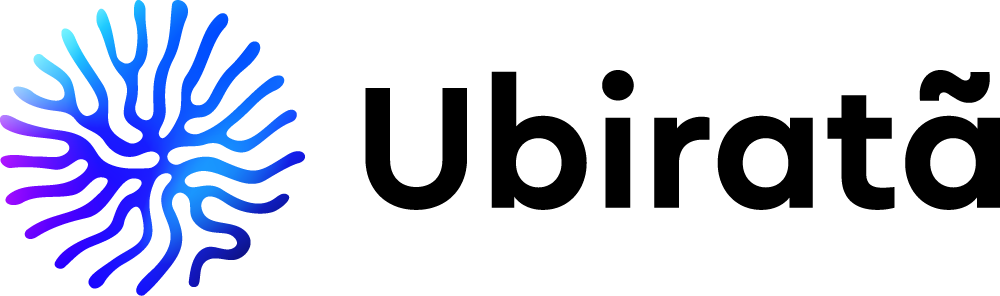

# Bibliotecas

In [430]:
! pip install xgboost -U --quiet

In [433]:
import  pandas as pd
import  numpy as np
import  plotly.express as px
import  plotly.graph_objects as go
import  xgboost as xgb
import time

from    google.colab import drive
from    statsmodels.stats.outliers_influence import variance_inflation_factor
from    sklearn.preprocessing import StandardScaler
from    sklearn.model_selection import (train_test_split,
                                        RandomizedSearchCV)
from    sklearn.metrics import (r2_score,
                                mean_squared_error,
                                mean_absolute_error,
                                max_error,
                                mean_absolute_percentage_error)
from    sklearn.ensemble import RandomForestRegressor

In [145]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [293]:
np.random.seed(31)

# Dataset

* bloco: índice da região de plantação e colheita de cana-de-açúcar
* talhao: índice da sub-região de plantação e colheita de cana-de-açúcar (Um bloco contém diversos talhões)
* area: área do talhão
* safra: ano que a cana-de-açúcar de cada talhão foi colhida
* data_colheita: data em que a cana-de-açúcar foi colhida
* TCH: Toneladas de cana-de-açúcar colhida por hectare
* NDVI_b01: NDVI é o nome dado a um popular índice de vegetação, e o “b01” corresponde ao índice no primeiro mês antes da colheita
* NDVI_bN: NDVI no N-ésimo mês antes da colheita

NDVI é a sigla para Índice de Vegetação da Diferença Normalizada (Normalized Difference Vegetation Index – do inglês).

É um índice usado para medir a saúde e a densidade da vegetação através de imagens de satélite, auxiliando no monitoramento das lavouras, e nas tomadas de decisão relacionadas ao manejo da cultura.

Este índice apresenta variação numérica de -1 a +1, sendo os valores positivos referentes ao vigor vegetativo da cultura, enquanto que os valores negativos indicam presença de água ou ausência de vegetação.

In [420]:
df = pd.read_csv('/content/drive/MyDrive/Teste Ubiratã/dataset_tch.csv',
                 sep=',',
                 encoding='utf-8')

df['data_colheita'] = pd.to_datetime(df['data_colheita'], format='%Y-%m-%d')

df.sort_values(by='data_colheita', inplace=True)

df.reset_index(drop=True, inplace=True)

df.head()

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534


# a)
Faça uma rápida análise exploratória desse dataset, por exemplo análises estatísticas das variáveis, gráficos de distribuição, etc.

In [147]:
df['safra'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [148]:
df.shape

(1906, 18)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   bloco          1906 non-null   int64         
 1   talhao         1906 non-null   int64         
 2   area           1906 non-null   float64       
 3   safra          1906 non-null   int64         
 4   data_colheita  1906 non-null   datetime64[ns]
 5   TCH            1632 non-null   float64       
 6   NDVI_b01       1906 non-null   float64       
 7   NDVI_b02       1906 non-null   float64       
 8   NDVI_b03       1906 non-null   float64       
 9   NDVI_b04       1906 non-null   float64       
 10  NDVI_b05       1906 non-null   float64       
 11  NDVI_b06       1906 non-null   float64       
 12  NDVI_b07       1906 non-null   float64       
 13  NDVI_b08       1906 non-null   float64       
 14  NDVI_b09       1906 non-null   float64       
 15  NDVI_b10       1906 n

In [419]:
df[df.isnull().any(axis=1)]

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


In [417]:
# Verifica dados null em safras diferente de 2019
df[(df.isnull().any(axis=1)) &
   (df['safra'] != 2019)].transpose()

""
bloco
talhao
area
safra
data_colheita
TCH
NDVI_b01
NDVI_b02
NDVI_b03
NDVI_b04


In [177]:
df_2014_2018 = df[df['safra'] != 2019].copy()

## Estatística descritiva

In [416]:
df_2014_2018.drop(columns=['bloco', 'talhao', 'area', 'safra']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TCH,1632.0,75.234768,29.310767,2.202214,55.833929,74.971461,94.822667,149.940000
NDVI_b01,1632.0,0.534673,0.105107,0.298283,0.458951,0.514620,0.607857,0.822115
NDVI_b02,1632.0,0.564495,0.108507,0.287979,0.482802,0.545404,0.646742,0.845474
NDVI_b03,1632.0,0.601389,0.106995,0.297742,0.517665,0.600873,0.690522,0.833968
NDVI_b04,1632.0,0.642186,0.101480,0.304709,0.566234,0.663929,0.719432,0.834416
NDVI_b05,1632.0,0.661202,0.094809,0.308280,0.617135,0.684114,0.727902,0.847569
NDVI_b06,1632.0,0.661775,0.088612,0.325235,0.615927,0.682218,0.724550,0.815664
NDVI_b07,1632.0,0.642998,0.103593,0.284499,0.591899,0.667638,0.719172,0.817458
NDVI_b08,1632.0,0.622131,0.115120,0.221697,0.550753,0.648504,0.711083,0.840642
NDVI_b09,1632.0,0.574515,0.122088,0.161224,0.488638,0.590327,0.672990,0.805076


In [405]:
fig = px.box(df_2014_2018,
             y='TCH',
             x='safra',
             color='safra')

fig.update_layout(height=500,
                    width=1200,
                    showlegend=False,
                    plot_bgcolor='#F9F9F9',
                    paper_bgcolor='#F9F9F9',
                    margin=dict(l=50,
                                r=50,
                                b=50,
                                t=50,
                                pad=0),
                    title='Toneladas de cana-de-açúcar',
                    yaxis={'showgrid': True,
                           'title': '',
                           'dtick': 25,
                           'gridcolor': '#CBC9CD'},
                    xaxis={'showgrid': False,
                           'title': ''})

In [412]:
# Menor produção
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].min()].transpose()

,171
bloco,119
talhao,6
area,115.53
safra,2014
data_colheita,2014-09-09 00:00:00
TCH,2.202214
NDVI_b01,0.460535
NDVI_b02,0.484786
NDVI_b03,0.545309
NDVI_b04,0.620704


In [413]:
# Maior produção
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].max()].transpose()

,1277
bloco,387
talhao,2
area,81.39
safra,2018
data_colheita,2018-07-12 00:00:00
TCH,149.94
NDVI_b01,0.505337
NDVI_b02,0.539612
NDVI_b03,0.593915
NDVI_b04,0.625662


## TCH por safra

In [154]:
df_safra_tch = pd.DataFrame(df_2014_2018.groupby('safra')['TCH'].sum())

df_safra_tch.reset_index(drop=False, inplace=True)

df_safra_tch = df_safra_tch[df_safra_tch['safra'] != 2019]

df_safra_tch['mil_TCH'] = df_safra_tch['TCH'] / 1000

df_safra_tch

,safra,TCH,mil_TCH
0,2014,27877.678743,27.877679
1,2015,8294.836061,8.294836
2,2016,4160.731266,4.160731
3,2017,38653.503679,38.653504
4,2018,43796.391863,43.796392


In [407]:
df_safra_tch['mil_TCH'].describe()

count     5.000000
mean     24.556628
std      17.750762
min       4.160731
25%       8.294836
50%      27.877679
75%      38.653504
max      43.796392
Name: mil_TCH, dtype: float64

In [421]:
fig = px.line(df_safra_tch, x='safra', y='mil_TCH',
              color_discrete_sequence=['#845EC2'],
              markers=True,
              text=round(df_safra_tch['mil_TCH'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0),
                  title='Total de cana-de-açúcar por safra (em mil toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

## TCH por bloco

In [423]:
df_tch_bloco = pd.DataFrame(df_2014_2018.groupby(['bloco', 'talhao', 'safra'])['TCH'].sum()).sort_values(['safra', 'bloco', 'talhao',])

df_tch_bloco

TCH
bloco talhao safra            
5     11     2014   139.887515
8     1      2014    75.522509
      2      2014    93.504762
      3      2014    69.645161
      11     2014    51.913213
...                        ...
476   2      2018   109.175083
      3      2018   109.014847
      5      2018   136.491803
477   2      2018   113.414317
478   1      2018    38.567886

[1632 rows x 1 columns]

In [424]:
df_2014_2018[(df_2014_2018['bloco'] == 54) &
             (df_2014_2018['safra'] == 2014)].transpose()

,216,220
bloco,54,54
talhao,2,1
area,71.04,50.76
safra,2014,2014
data_colheita,2014-10-15 00:00:00,2014-10-15 00:00:00
TCH,23.255934,102.644014
NDVI_b01,0.484126,0.463475
NDVI_b02,0.455011,0.441425
NDVI_b03,0.533778,0.507897
NDVI_b04,0.572209,0.548174


In [427]:
df_bloco_talhao = df_2014_2018.copy()

df_bloco_talhao['talhao'] = df_2014_2018['talhao'].astype(str)

fig = px.bar(df_bloco_talhao, x='bloco', y='TCH', color='talhao', animation_frame='safra')

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Toneladas de cana-de-açúcar por bloco e safra<br>(Soma por talhões)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'})

## Correlações e multicolinearidade

In [470]:
features = df.drop(['TCH'], axis=1).columns

features = features.drop('data_colheita')

features

Index(['bloco', 'talhao', 'area', 'safra', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03',
       'NDVI_b04', 'NDVI_b05', 'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09',
       'NDVI_b10', 'NDVI_b11', 'NDVI_b12'],
      dtype='object')

In [471]:
target = df.drop(features, axis=1).columns

target = target.drop('data_colheita')

target

Index(['TCH'], dtype='object')

In [300]:
X = df_2014_2018[features]

y = df_2014_2018[target]

In [301]:
X

,bloco,talhao,area,safra,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,250,1,117.77,2018,0.426203,0.411605,0.468109,0.529646,0.619639,0.685097,0.682860,0.659134,0.572820,0.577737,0.500272,0.362951
1628,395,3,36.02,2018,0.442258,0.421180,0.469074,0.532711,0.596744,0.660622,0.691889,0.556852,0.535244,0.464160,0.452601,0.348077
1629,395,2,95.93,2018,0.386034,0.350786,0.391144,0.486252,0.582478,0.658411,0.708954,0.578486,0.545224,0.445497,0.405178,0.333850
1630,395,1,99.16,2018,0.382209,0.351820,0.389025,0.484159,0.580233,0.674486,0.731810,0.606615,0.572842,0.461748,0.415816,0.339220


In [302]:
y

,TCH
0,69.645161
1,75.522509
2,93.504762
3,51.913213
4,113.746898
...,...
1627,20.071738
1628,21.880668
1629,21.568922
1630,31.638724


In [254]:
correlacao = X.corr().round(2)

fig = px.imshow(correlacao, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r')

fig.update_layout(margin=dict(t=50,
                              r=50,
                              b=50,
                              l=50),
                  showlegend=False,
                  coloraxis_showscale=False,
                  width=800,
                  height=800)

fig.update_xaxes(side='top')

In [428]:
df_vif = pd.DataFrame()

df_vif['feature'] = X.columns

df_vif['variance_inflation_factor'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]


fig = go.Figure(go.Bar(y=df_vif['feature'],
                       x=df_vif['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#845EC2'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': True})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=False)

In [260]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [429]:
df_vif_scaled = pd.DataFrame()

df_vif_scaled['feature'] = X.columns

df_vif_scaled['variance_inflation_factor'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]


fig = go.Figure(go.Bar(y=df_vif_scaled['feature'],
                       x=df_vif_scaled['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif_scaled['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#845EC2'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância<br>Fatures redimensionadas',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': False})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=True)

Uma recomendação é que se o VIF for maior que 5, então a variável explicativa representada por exog_idx está altamente colinear com as outras variáveis explicativas e as estimativas dos parâmetros terão grandes erros padrão por causa disso.

# b)

Desenvolva um modelo capaz de prever o TCH dos blocos do dataset para a safra de 2019 (atenção que a previsão deve ser no nível de blocos e não de talhões).

In [365]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3)

print('\nShape of X_treino: ', X_treino.shape)
print('Shape of y_treino: ', y_treino.shape)

print('\nShape of X_teste: ', X_teste.shape)
print('Shape of y_teste: ', y_teste.shape)


Shape of X_treino:  (1142, 16)
Shape of y_treino:  (1142, 1)

Shape of X_teste:  (490, 16)
Shape of y_teste:  (490, 1)


In [366]:
X_treino_scaled = scaler.fit_transform(X_treino)

X_teste_scaled = scaler.transform(X_teste)

Aplica-se .fit_transform() em X_treino enquanto usamos .transform() em X_test.

Isso é feito para dimensionar o conjunto de teste com os mesmos parâmetros do conjunto de treinamento, mas evitar vazamento de dados.

fit_transform calcula os valores de escala e os aplica, enquanto .transform apenas aplica os valores calculados.

## XGBoost

In [567]:
t1 = time.perf_counter()


# Modelo XGBoost Regressor
modelo_xgbr = xgb.XGBRegressor()

params_xgbr = {'n_estimators':  [300, 400, 500, 600, 1000],
               'learning_rate': [0.1, 0.01, 0.001],
               'booster':       ['dart', 'gbtree'],  # Tree based models
               'eval_metric':   ['mae'],
               'objective':     ['reg:squarederror']}


# Random search dos melhores parametros
xgbr_rand_search = RandomizedSearchCV(modelo_xgbr,
                                      param_distributions=params_xgbr,
                                      n_iter=5,
                                      cv=5,
                                      scoring='neg_mean_squared_error',
                                      error_score='raise',
                                      verbose=3)

xgbr_rand_search.fit(X_treino_scaled, y_treino)


# Define o modelo XGBRegressor com melhores parâmetros
melhor_xgbr_regressor = xgbr_rand_search.best_estimator_

modelo_xgbr_fit = melhor_xgbr_regressor.fit(X_treino_scaled,
                                         y_treino,
                                         verbose=False)

pred_xgbr_teste = melhor_xgbr_regressor.predict(X_teste_scaled)

pred_xgbr_teste = pd.Series(pred_xgbr_teste, index=y_teste.index)

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=gbtree, eval_metric=mae, learning_rate=0.01, n_estimators=500, objective=reg:squarederror;, score=-677.323 total time=   3.6s
[CV 2/5] END booster=gbtree, eval_metric=mae, learning_rate=0.01, n_estimators=500, objective=reg:squarederror;, score=-650.930 total time=   2.1s
[CV 3/5] END booster=gbtree, eval_metric=mae, learning_rate=0.01, n_estimators=500, objective=reg:squarederror;, score=-568.183 total time=   1.9s
[CV 4/5] END booster=gbtree, eval_metric=mae, learning_rate=0.01, n_estimators=500, objective=reg:squarederror;, score=-480.687 total time=   3.1s
[CV 5/5] END booster=gbtree, eval_metric=mae, learning_rate=0.01, n_estimators=500, objective=reg:squarederror;, score=-644.569 total time=   4.9s
[CV 1/5] END booster=gbtree, eval_metric=mae, learning_rate=0.1, n_estimators=600, objective=reg:squarederror;, score=-706.871 total time=   2.3s
[CV 2/5] END booster=gbtree, eval_metric=mae, learning_rate

In [568]:
pred_xgbr_teste

868     78.768822
1267    82.635269
1308    66.062195
305     82.403252
782     70.502258
          ...    
233     81.728325
243     40.817169
823     79.281136
218     92.438118
892     68.975395
Length: 490, dtype: float32

In [569]:
xgbr_rand_search.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 500,
 'learning_rate': 0.01,
 'eval_metric': 'mae',
 'booster': 'gbtree'}

In [570]:
# Métricas de avaliacao
rmse_xgbr_teste = mean_squared_error(y_teste, pred_xgbr_teste.values, squared=False)
rmse_xgbr_teste = round(rmse_xgbr_teste, 2)
print(f'RMSE XGBoost teste: {rmse_xgbr_teste}')

mae_xgbr_teste = mean_absolute_error(y_teste, pred_xgbr_teste.values)
mae_xgbr_teste = round(mae_xgbr_teste, 2)
print(f'MAE XGBoost teste: {mae_xgbr_teste}')

max_error_xgbr_teste = max_error(y_teste, pred_xgbr_teste.values)
max_error_xgbr_teste = round(max_error_xgbr_teste, 2)
print(f'Max error XGBoost teste: {max_error_xgbr_teste}')

mape_xgbr_teste = mean_absolute_percentage_error(y_teste, pred_xgbr_teste.values) * 100
mape_xgbr_teste = round(mape_xgbr_teste, 2)
print(f'MAPE XGBoost teste: {rmse_xgbr_teste}%')

RMSE XGBoost teste: 26.14
MAE XGBoost teste: 20.26
Max error XGBoost teste: 90.34
MAPE XGBoost teste: 26.14%


## Random forest

In [466]:
t1 = time.perf_counter()


# Modelo Random Forest
rand_forest_regressor = RandomForestRegressor()

param_space = {'bootstrap': [True, False],
               'criterion': ['squared_error'], # 'absolute_error', 'friedman_mse', 'poisson'],
               'max_depth': [2, 4, 8, 16, 32],
               'min_samples_leaf': [2, 3, 4],
               'min_samples_split': [2, 3, 4, 5],
               'n_estimators': [300, 400, 500, 600, 1000]}

# Random search dos melhores parametros
rand_forest_search = RandomizedSearchCV(rand_forest_regressor,
                                        param_space,
                                        scoring='neg_mean_absolute_error',
                                        n_iter=5,
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=3)

rand_forest_search.fit(X_treino_scaled, np.ravel(y_treino))


# Define o modelo Random Forest com melhores parâmetros
melhor_rand_forest_regressor = RandomForestRegressor(**rand_forest_search.best_params_)

melhor_rand_forest_regressor.fit(X_treino_scaled, np.ravel(y_treino))

pred_rand_forest_teste = melhor_rand_forest_regressor.predict(X_teste_scaled)

pred_rand_forest_teste = pd.Series(pred_rand_forest_teste, index=y_teste.index)

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Tempo de execução: 79.49 segundos
Tempo de execução: 1.32 minutos


In [467]:
# Métricas de avaliacao
rmse_rand_forest_teste = mean_squared_error(y_teste, pred_rand_forest_teste.values, squared=False)
rmse_rand_forest_teste = round(rmse_rand_forest_teste, 2)
print(f'RMSE Random Forest teste: {rmse_rand_forest_teste}')

mae_rand_forest_teste = mean_absolute_error(y_teste, pred_rand_forest_teste.values)
mae_rand_forest_teste = round(mae_rand_forest_teste, 2)
print(f'MAE Random Forest teste: {mae_rand_forest_teste}')

max_error_rand_forest_teste = max_error(y_teste, pred_rand_forest_teste.values)
max_error_rand_forest_teste = round(max_error_rand_forest_teste, 2)
print(f'Max error Random Forest teste: {max_error_rand_forest_teste}')

mape_rand_forest_teste = mean_absolute_percentage_error(y_teste, pred_rand_forest_teste.values) * 100
mape_rand_forest_teste = round(mape_rand_forest_teste, 2)
print(f'MAPE Random Forest teste: {rmse_rand_forest_teste}%')

RMSE Random Forest teste: 25.65
MAE Random Forest teste: 19.8
Max error Random Forest teste: 92.43
MAPE Random Forest teste: 25.65%


# c)
Qual o erro esperado do modelo para a safra de 2019? Utilize a métrica de erro que você julgar necessária, podendo ser utilizada mais de uma.

## Análise de métricas

In [468]:
metricas = [[rmse_xgbr_teste, mae_xgbr_teste, max_error_xgbr_teste, mape_xgbr_teste],
            [rmse_rand_forest_teste, mae_rand_forest_teste, max_error_rand_forest_teste, mape_rand_forest_teste]]

colunas = ['rmse', 'mae', 'max_error', 'mape']

index = ['xgbr_teste', 'rand_forest']

df_metricas = pd.DataFrame(data=metricas,
                           columns=colunas,
                           index=index)

df_metricas

,rmse,mae,max_error,mape
xgbr_teste,26.13,20.23,90.64,44.89
rand_forest,25.65,19.80,92.43,43.80


## Pred TCH 2019

In [571]:
df_2019 = df[df['safra'] == 2019].copy()

df_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


In [572]:
X_validacao = df_2019[features]

y_validacao = df_2019[target]

In [573]:
X_validacao_scaled = scaler.transform(X_validacao)

In [587]:
X_validacao_scaled.shape

(274, 16)

In [574]:
X_validacao_scaled

array([[ 0.63808875, -0.80123498,  0.80264578, ...,  0.69255088,
         1.15822187,  0.7094507 ],
       [ 0.18352819, -0.80123498,  1.62588654, ...,  2.28821864,
         1.90203162,  1.82754873],
       [ 0.18352819,  0.07516576,  0.1692551 , ...,  1.32835262,
         1.19822604,  1.04317988],
       ...,
       [ 1.08494489, -0.80123498,  0.80030608, ...,  1.43610083,
         0.62750863, -0.52202675],
       [-0.07842196, -0.80123498,  1.52962453, ...,  3.38434122,
         2.50098602,  1.64861342],
       [ 0.57645342, -0.36303461, -1.48524827, ...,  2.13478733,
         1.18156787,  0.79516531]])

In [581]:
t1 = time.perf_counter()

pred_tch_2019 = melhor_rand_forest_regressor.predict(X_validacao_scaled)

pred_tch_2019 = pd.Series(pred_tch_2019, index=y_validacao.index)

y_validacao['TCH'] = pred_tch_2019

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.06 segundos
Tempo de execução: 0.00 minutos


In [582]:
y_validacao

,TCH
1632,107.414160
1633,99.797835
1634,79.757618
1635,49.349328
1636,47.253640
...,...
1901,72.364794
1902,88.309552
1903,73.822050
1904,81.268236


In [583]:
df_pred_2019 = df.copy()

df_pred_2019['TCH'] = df_pred_2019['TCH'].fillna(pred_tch_2019)

df_pred_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,72.364794,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,88.309552,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,73.822050,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,81.268236,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


In [584]:
fig = px.box(df_pred_2019,
             y='TCH',
             x='safra',
             color='safra')

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0),
                  title='Toneladas de cana-de-açúcar',
                  yaxis={'showgrid': True,
                         'title': '',
                         'dtick': 25,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [585]:
df_safra_tch_2019 = pd.DataFrame(df_pred_2019.groupby('safra')['TCH'].sum())

df_safra_tch_2019.reset_index(drop=False, inplace=True)

df_safra_tch_2019['mil_TCH'] = df_safra_tch_2019['TCH'] / 1000

df_safra_tch_2019

,safra,TCH,mil_TCH
0,2014,27877.678743,27.877679
1,2015,8294.836061,8.294836
2,2016,4160.731266,4.160731
3,2017,38653.503679,38.653504
4,2018,43796.391863,43.796392
5,2019,21006.732830,21.006733


In [586]:
fig = px.line(df_safra_tch_2019, x='safra', y='mil_TCH',
              color_discrete_sequence=['#845EC2'],
              markers=True,
              text=round(df_safra_tch_2019['mil_TCH'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0),
                  title='Total de cana-de-açúcar por safra (em mil toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')